In [76]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 5]

# Redistribution

Generate directed payments between MCOs and NPI such that:

    1. All NPIs are paid exactly what they claimed (no more and no less)
    2. All MCOs pay no more than what they were allocated

Additional tuning can be applied (if desired) such that (for example):

    * MCOs pay no less than 98% of their allocation and no more than 100%

Currently it is constrained only that MCOs pay no more than 100% of their allocation.

### Read in the data and set initial values

To start, each MCO will be directed to pay an equal share of each NPI. For example,
if NPI `1003824038` is contracted with 4 MCOs, each MCO will pay 25% of what the NPI claimed.

This percent (i.e., 25%) will be modified by the algorithm within the above constraints.

In [2]:
full_df = pd.read_csv("../data/redistribution_model.csv", index_col=None)
full_df.drop(axis = 1,
            labels = [x for x in full_df.columns if not x in ['NPI', 'MCO', 'npi_total_claimed', 'mco_total_allocated']],
            inplace = True)
# Apply the baseline percent within each npi
# Just basically if there are 4 MCO, their percents are all .25
full_df['mco_share_of_npi'] = 1 / full_df.groupby('NPI')['NPI'].transform('count')
full_df.head()

,NPI,MCO,npi_total_claimed,mco_total_allocated,mco_share_of_npi
0,1003824038,Amerigroup,8.364274e+06,1.865729e+08,0.250000
1,1003824038,El Paso First Health Plan,8.364274e+06,5.177905e+06,0.250000
2,1003824038,Molina Healthcare of Texas,8.364274e+06,5.675436e+07,0.250000
3,1003824038,Superior Health Plan,8.364274e+06,7.772697e+07,0.250000
4,1013942150,Amerigroup,1.967945e+06,1.865729e+08,0.333333


### Define algorithm subfunctions

In [3]:
# Define functions to update data
# Given a `mco_share_of_npi`, calculate the directed payment itself
def calculate_dp(input_df, claim_col = 'npi_total_claimed', share_of_npi_col = 'mco_share_of_npi'):
    df = input_df.copy()
    df['dp'] = df[claim_col] * df[share_of_npi_col]
    return df

# Function to calculate what percent a given dp is of the MCO's budget
def calculate_percent_of_allocation(input_df, dp_col = 'dp', total_allocation_col = 'mco_total_allocated'):
    df = input_df.copy()
    df['dp_pct_of_allocation'] = df[dp_col] / df[total_allocation_col]
    return df

# Define function to compute fraction of the budget each MCO is using on a given NPI payment
def calculate_mco_pct_budget_spent(input_df, budget_column='dp_pct_of_allocation', group_column='MCO'):
    # Create a copy of the input DataFrame to avoid modifying the original
    df = input_df.copy()
    # Calculate the sum of 'dp_percent_of_budget' within each 'MCO' group
    df['mco_pct_budget_spent'] = df.groupby(group_column, group_keys=False)[budget_column].transform('sum')
    return df

# Calculate percent of claimed dollars paid
def calculate_npi_paid(input_df, claim_col = 'npi_total_claimed', dp_col = 'dp', group_col = 'NPI'):
    df = input_df.copy()
    df['npi_pct_received_of_claimed'] = df.groupby(group_col, group_keys = False)[dp_col].transform('sum') / df[claim_col]
    return df

# Run all steps
def update(input_df):
    df = input_df.copy()
    df = calculate_dp(df)
    df = calculate_percent_of_allocation(df)
    df = calculate_mco_pct_budget_spent(df)
    df = calculate_npi_paid(df)
    return df

# A function to compute the sum of squared devations above 1
def score_mco(input_df):
    df = input_df.copy()
    x = df.loc[~df[['MCO', 'mco_pct_budget_spent']].duplicated(), 'mco_pct_budget_spent']
    x[x < 1] = 1
    return np.mean((x - 1)**2)


### Continue initializing values

Some subfunctions also calculate the objective functions, which the algorithm uses to determine when the optimal redistribution has been found. Run these on the initial values.

In [4]:

full_df = update(full_df)
full_df.head()

,NPI,MCO,npi_total_claimed,mco_total_allocated,mco_share_of_npi,dp,dp_pct_of_allocation,mco_pct_budget_spent,npi_pct_received_of_claimed
0,1003824038,Amerigroup,8.364274e+06,1.865729e+08,0.250000,2.091069e+06,0.011208,0.704061,1.0
1,1003824038,El Paso First Health Plan,8.364274e+06,5.177905e+06,0.250000,2.091069e+06,0.403845,1.037421,1.0
2,1003824038,Molina Healthcare of Texas,8.364274e+06,5.675436e+07,0.250000,2.091069e+06,0.036844,2.165373,1.0
3,1003824038,Superior Health Plan,8.364274e+06,7.772697e+07,0.250000,2.091069e+06,0.026903,0.717957,1.0
4,1013942150,Amerigroup,1.967945e+06,1.865729e+08,0.333333,6.559816e+05,0.003516,0.704061,1.0


In [5]:
print(f"The value of the objective function at the time of initialization: {score_mco(full_df)}.",
      "\n", "\n",
      """Note, the objective function is the mean squared deviations above 1, applied to the `mco_pct_budget_spent` column,
      where 1 indicates an MCO is spending 100 percent of their allocation.""")

The value of the objective function at the time of initialization: 5.623065446322087. 
 
 Note, the objective function is the mean squared deviations above 1, applied to the `mco_pct_budget_spent` column,
      where 1 indicates an MCO is spending 100 percent of their allocation.


In [ ]:
# Test the algorithm if desired:

# test_df = full_df.head(6).copy()
# print(test_df)
# insert_df = full_df.iloc[4:6, ::].copy()
# insert_df.reset_index(drop=True, inplace = True)
# # insert_df.loc[0, 'npi_pct_received_of_claimed'] = 2
# insert_df.at[0, 'npi_pct_received_of_claimed'] = 2
# insert_df.at[1, 'npi_pct_received_of_claimed'] = 3
# print(insert_df)
# test_df.loc[test_df[test_df['NPI'] == 1013942150].index] = insert_df.values
# #test_df.loc[test_df['NPI'] == 1013942150, :] = insert_df
# test_df

## Run the Algorithm

In [ ]:

scores = []#global scores # lists are mutable so no need for global
pct_budget_iterations = []
npi_share_iterations = []
def redistribute(input_df, max_iterations = 100):
    df = input_df.copy()
    iteration = 0
    # If none of the MCOs need adjustment, we're done.
    #complete = df[df.mco_pct_budget_spent > 1].shape[0] == 0
    # We can try other constraints (to see if possible to get closer to exactly optimal
    complete = all((df['mco_pct_budget_spent'] >= 0.98) & (df['mco_pct_budget_spent'] <= 1.0))
    while iteration < max_iterations and not complete:
        print(f'Iteration: {iteration}. Searching for NPI')
        iteration += 1
        npi_found = False
        while not npi_found:
            # 1. Randomly select an NPI group in the data
            npi_ = np.random.choice(df['NPI'].unique())
            npi_df = df[df.NPI == npi_].copy()
            npi_df.reset_index(drop = True, inplace = True) # Later insert back by filtering for npi_ again
            # 2. If all mco_pct_budget_spent for all MCO in that NPI group are <= 1, return to step 1, else proceed
            # For modified objective, change the npi_found criteria to be the same as `complete`
            npi_found = any(npi_df.mco_pct_budget_spent > 1)
            #npi_found = any((npi_df['mco_pct_budget_spent'] < 0.98) | (npi_df['mco_pct_budget_spent'] > 1.0))
            #print(f"NPI: {npi_}", f"Budget percents: {npi_df.mco_pct_budget_spent}")
        # Step 3: Decrease the largest mco_pct_budget_spent by 2.5% of itself
        print(f'Proceeding with redistribution for NPI {npi_}')
        max_mco_idx = npi_df.mco_pct_budget_spent.idxmax() # since index is reset, returns same as argmax
        old_dp_pct = npi_df.at[max_mco_idx, 'dp_pct_of_allocation']
        npi_df.at[max_mco_idx, 'dp_pct_of_allocation'] = old_dp_pct * 0.975
        # store the old dp before next step
        old_dp = npi_df.at[max_mco_idx, 'dp']
        # 4. Recalculate that MCO's new `dp` as mco_pct_budget_spent * mco_total_allocated
        npi_df['dp'] = npi_df.dp_pct_of_allocation * npi_df.mco_total_allocated
        # 5. Store the difference of this MCO's old `dp` minus the new `dp`
        dp_difference_dollars = old_dp - npi_df.at[max_mco_idx, 'dp']
        # 6. Divide the difference by (N - 1), where N are the number of MCO in this NPI group, and add that quotient to all other MCO's `dp` in this group
        N = npi_df.shape[0]
        redistribution_amt = dp_difference_dollars / (N - 1)
        npi_df.loc[~npi_df.index.isin([max_mco_idx]), 'dp'] += redistribution_amt
        # 5. Recalculate the dp_pct_of_allocation as dp / mco_total_allocated for all MCO in group
        npi_df['dp_pct_of_allocation'] = npi_df.dp / npi_df.mco_total_allocated
        # 6. Recaulculate mco_share_of_npi as dp / npi_total_claimed
        npi_df['mco_share_of_npi'] = npi_df.dp / npi_df.npi_total_claimed
        # 7. Recalculate mco_pct_budget_spent using helper function calculate_mco_pct_budget_spent
        npi_df = calculate_mco_pct_budget_spent(npi_df)
        # # 8. Recalculate npi_pct_received_of_claimed using helper function calculate_npi_paid
        npi_df = calculate_npi_paid(npi_df)
    
        # IF the npi paid amount is still all 1, add this back into the original data, else skip
        # Right now this check is not implemented... to do...
        df.loc[df[df['NPI'] == npi_].index] = npi_df.values
        # Update the two columns that incorporate information across NPI groups together
        df = calculate_mco_pct_budget_spent(df)
        df = calculate_npi_paid(df)

        # Add to the score vector
        scores.append(score_mco(df))
        print(f"Iteration score: {scores[iteration - 1]}")

        # During development, store other outputs
        ### To track the progress in allocation expenditures towards 100%
        pct_budget_iterations.append(df[['MCO', 'mco_pct_budget_spent']].groupby(['MCO', 'mco_pct_budget_spent']).nth(0))
        # To track the changes within MCO (to determine if a model could be used at each step, e.g. regression model)
        npi_share_iterations.append(df[['NPI', 'MCO', 'mco_share_of_npi']])

        # Re-check if the redistribution is complete
        #complete = df[df.mco_pct_budget_spent > 1].shape[0] == 0
        complete = all((df['mco_pct_budget_spent'] >= 0.98) & (df['mco_pct_budget_spent'] <= 1.0))
        # An easy way to just stop early if complete
        if complete:
            return df
    
    return df

redist_df = redistribute(full_df, max_iterations = 20000)
    

In [ ]:
print(f"Final objective function value: {scores[len(scores) - 1]}")
print(f"Maximum MCO expenditure: {round(redist_df.mco_pct_budget_spent.max(), 4) * 100}%")
print(f"Minimum MCO expenditure: {round(redist_df.mco_pct_budget_spent.min(), 4) * 100}%")

In [ ]:
%matplotlib inline

# Plot the numbers as a line graph
plt.plot(scores, marker='')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Mean squared deviation above 1')
plt.show()


In [ ]:
redist_df.to_csv(f"../data/redist_results_{str(dt.date.today())}.csv", index=False)

In [62]:
# Parameterize further
def complete(input_df, cutoff = 1.0):
    
    return input_df[input_df.mco_pct_budget_spent > cutoff].shape[0] == 0

def sample_step(df, cutoff = 1.0):
    npi_found = False
    while not npi_found:
        npi_ = np.random.choice(df['NPI'].unique())
        npi_df = df[df.NPI == npi_].copy()
        npi_df.reset_index(drop = True, inplace = True) # Later insert back by filtering for npi_ again
        npi_found = any(npi_df.mco_pct_budget_spent > cutoff)
    return npi_df

def redistribution_step(df, shrinkage = 0.975):
    df_ = df.copy()
    max_mco_idx = df_.mco_pct_budget_spent.idxmax() # since index is reset, returns same as argmax
    old_dp_pct = df_.at[max_mco_idx, 'dp_pct_of_allocation']
    df_.at[max_mco_idx, 'dp_pct_of_allocation'] = old_dp_pct * shrinkage
    # store the old dp before next step
    old_dp = df_.at[max_mco_idx, 'dp']
    # 4. Recalculate that MCO's new `dp` as mco_pct_budget_spent * mco_total_allocated
    df_['dp'] = df_.dp_pct_of_allocation * df_.mco_total_allocated
    # 5. Store the difference of this MCO's old `dp` minus the new `dp`
    dp_difference_dollars = old_dp - df_.at[max_mco_idx, 'dp']
    # 6. Divide the difference by (N - 1), where N are the number of MCO in this NPI group, and add that quotient to all other MCO's `dp` in this group
    N = df_.shape[0]
    redistribution_amt = dp_difference_dollars / (N - 1)
    df_.loc[~df_.index.isin([max_mco_idx]), 'dp'] += redistribution_amt
    df_['dp_pct_of_allocation'] = df_.dp / df_.mco_total_allocated
    df_['mco_share_of_npi'] = df_.dp / df_.npi_total_claimed
    # The next 2 could probably be done only in update but need to confirm
    df_ = calculate_mco_pct_budget_spent(df_)
    df_ = calculate_npi_paid(df_)
    return df_

def update_step(df, subset):
    df_ = df.copy()
    subset_ = subset.copy()
    npi_ = subset_.NPI[0]
    df_.loc[df_[df_['NPI'] == npi_].index] = subset_.values
    df_ = calculate_mco_pct_budget_spent(df_)
    df_ = calculate_npi_paid(df_)
    return df_
    
def redistribute_df(input_df_, cutoff_ = 1.0, shrinkage_ = 0.975, max_iterations_ = 10000, verbose = False, output = 'final'):
    """
    output (str): Either 'final' to return the last iteration, or 'all' to return a dict with said final result and other information about each iteration.
    """
    if output == 'final':
        print('Returning only the last iteration')
    elif output == 'all':
        print('Returning data from all iterations.')
        res = dict()
        res.update({
            'final_result': [],
            'scores': [],
            'MCO_budget_expenditures': [],
            'NPI_shares': []
            })
    else:
        raise Exception('See help... output (str) must either be "all" or "final"')
    df = input_df_.copy()
    iteration = 0
    completed = complete(df, cutoff_)
    while iteration < max_iterations_ and not completed:
        iteration += 1
        print(f'iteration {iteration}') if verbose else None
        subset = sample_step(df, cutoff_)
        print(f'NPI: {subset.NPI[0]}')  if verbose else None
        subset = redistribution_step(subset, shrinkage_)
        df = update_step(df, subset)
        df['score'] = score_mco(df)
        completed = complete(df, cutoff_)
        print(f"iteration score {iteration}: {round(score_mco(df), 4)}") if verbose else None
        # Update the output object(s) if necessary
        if output == 'all':
            res['final_result'] = df.copy()
            res['scores'].append(score_mco(res['final_result']))
            mbe = df[['MCO', 'mco_pct_budget_spent']].groupby(['MCO', 'mco_pct_budget_spent']).nth(0).copy()
            mbe.insert(0, 'iteration', iteration)
            res['MCO_budget_expenditures'].append(mbe)
            ns = df[['NPI', 'MCO', 'mco_share_of_npi']].copy()
            ns.insert(0, 'iteration', iteration)
            res['NPI_shares'].append(ns)
        if completed:
            #print(score_mco(df))
            return df if output == 'final' else res
    #print(score_mco(df))
    # If completion occurs as a result of reaching the maximum iterations
    return df if output == 'final' else res


In [65]:
redist_recurse_res = redistribute_df(full_df, max_iterations_= 20000, verbose = False, output='all')

Returning data from all iterations.


In [66]:
pd.concat(redist_recurse_res['MCO_budget_expenditures'])

,iteration,MCO,mco_pct_budget_spent
0,1,Amerigroup,0.704062
1,1,El Paso First Health Plan,1.037421
2,1,Molina Healthcare of Texas,2.165377
3,1,Superior Health Plan,0.717957
5,1,FIRSTCARE,0.959344
...,...,...,...
38,17372,BlueCross BlueShield,0.988847
39,17372,RightCare from Scott and White Health Plan,0.994363
74,17372,Parkland Community Health Plan,0.999311
97,17372,Community First Health Plan,0.998657


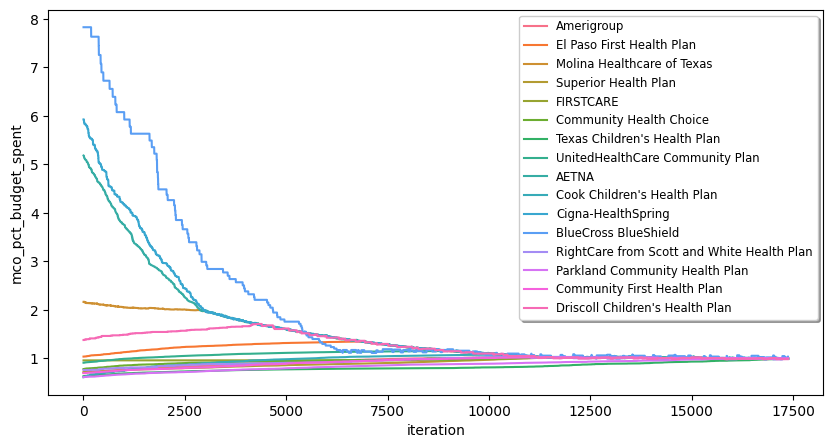

In [86]:
%matplotlib inline


lp = sns.lineplot(data=pd.concat(redist_recurse_res['MCO_budget_expenditures']), 
                  x="iteration", 
                  y="mco_pct_budget_spent", 
                  hue="MCO")
plt.legend(loc = 'upper right', shadow = True, fontsize = 'small')

In [83]:
help(plt.legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Place a legend on the Axes.
    
    Call signatures::
    
        legend()
        legend(handles, labels)
        legend(handles=handles)
        legend(labels)
    
    The call signatures correspond to the following different ways to use
    this method:
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line, = ax.plot([1, 2, 3])
        line.set_label('Label via method')
        ax.legend()
    
    .. note::
        Specific artists can be excluded from the automatic leg